In [1]:
%matplotlib inline


# Rhythmic Entrainment Source Separation (RESS) example

Find the linear combinations of multichannel data that maximize the
signal-to-noise ratio of the narrow-band steady-state response in the frequency
domain.

Uses `meegkit.RESS()`.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
from meegkit import ress
from meegkit.utils import fold, matmul3d, rms, snr_spectrum, unfold, gaussfilt

# import config

np.random.seed(1)

## Create synthetic data
Create synthetic data containing a single oscillatory component at 12 hz.



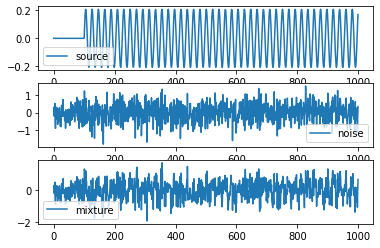

In [12]:
n_times = 1000
n_chans = 10
n_trials = 30
target = 12
sfreq = 250
noise_dim = 8
SNR = .2
t0 = 100

# source
source = np.sin(2 * np.pi * target * np.arange(n_times - t0) / sfreq)[None]
s = source * np.random.randn(n_chans, 1)
s = s[np.newaxis, :, :]
s = np.tile(s, (n_trials, 1, 1))
sign = np.zeros((n_trials, n_chans, n_times ))
sign[:, :, t0:] = s

# noise
noise = np.dot(
        np.random.randn(n_times * n_trials, noise_dim),
        np.random.randn(noise_dim, n_chans))
noise = noise.reshape((n_trials, n_times, n_chans))
noise = noise.transpose([0, 2, 1])

# mix signal and noise
signal = SNR * sign /  np.sqrt(np.mean(sign ** 2))
noise = noise / np.sqrt(np.mean(noise ** 2))
data = sign + noise

# Plot
f, ax = plt.subplots(3)
ax[0].plot(signal[0, 0, :], label='source')
ax[1].plot(noise[1, 0, :], label='noise')
ax[2].plot(data[1, 0, :], label='mixture')
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Enhance oscillatory activity using RESS



/home/dcas/l.darmet/python-meegkit/meegkit/ress.py:172: LinAlgWarning: Ill-conditioned matrix (rcond=6.81465e-18): result may not be accurate.
  from_ress = linalg.solve(B.T, A.T, overwrite_a=False)


(0.0, 40.0)

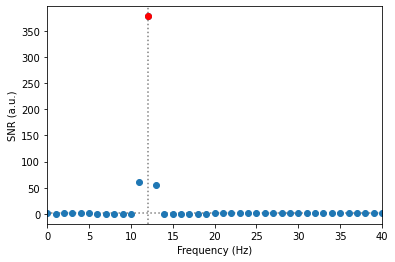

In [4]:
# Apply RESS
r = ress.RESS(sfreq=sfreq, peak_freq=target, compute_unmixing=True)
out = r.fit_transform(data)

# Compute PSD
nfft = 250
df = sfreq / nfft  # frequency resolution
bins, psd = ss.welch(np.squeeze(out), sfreq, window="hamming", nperseg=nfft,
                     noverlap=125, axis=1)
psd = psd.mean(axis=0, keepdims=True).T  # average over trials
snr = snr_spectrum(psd, bins, skipbins=2, n_avg=2)

f, ax = plt.subplots(1)
ax.plot(bins, snr, 'o', label='SNR')
ax.plot(bins[bins == target], snr[bins == target], 'ro', label='Target SNR')
ax.axhline(1, ls=':', c='grey', zorder=0)
ax.axvline(target, ls=':', c='grey', zorder=0)
ax.set_ylabel('SNR (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_xlim([0, 40])

Project components back into sensor space to see the effects of RESS on the
average SSVEP.



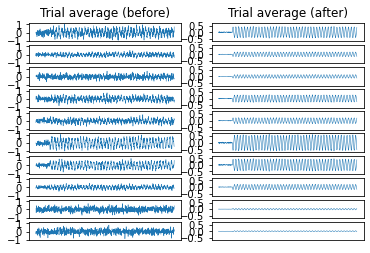

In [5]:
fromress = r.from_ress

proj = matmul3d(out, fromress)
f, ax = plt.subplots(n_chans, 2, sharey='col')
for c in range(data.shape[1]):
    ax[c, 0].plot(data[:, c, :].mean(0), lw=.5, label='data')
    ax[c, 1].plot(proj[:, c, :].mean(0), lw=.5, label='projection')
    if c < data.shape[1]:
        ax[c, 0].set_xticks([])
        ax[c, 1].set_xticks([])

ax[0, 0].set_title('Trial average (before)')
ax[0, 1].set_title('Trial average (after)')
plt.show()